# Chapter 02 - Unconstrained optimization

In [1]:
# Import required packages
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from utils import plot_contours

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 13

## Figure 2.1 

A exemplary function $f$ defined on a two-dimensional domain to visualize the optimization problem as a search for the minimum in a "mountaineous landscape".

In [2]:
def f(x):
    # This is a slight modification of Himmelblau's function
    return (
        (x[..., 0] ** 2 + x[..., 1] - 11) ** 2
        + (x[..., 0] + x[..., 1] ** 2 - 7) ** 2
        + x[..., 0]
        + x[..., 1]
    )


# Define the two-dimensional plot domain
x1 = torch.linspace(-5, 5, steps=100)
x2 = torch.linspace(-5, 5, steps=100)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)

# Create subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "surface"}]])
fig.add_trace(go.Contour(z=f(x), x=x1, y=x2, ncontours=25), row=1, col=1)
fig.add_trace(go.Surface(z=f(x), x=x1, y=x2), row=1, col=2)

# Plot settings
fig.update_traces(showscale=False)
fig.update_layout(autosize=False, width=1000, height=500)
fig.show()

## Example 9

The function $f_0(x, y)=x^2 + y^2$ is convex, as its Hessian 
$$
        \nabla^2f_0(x,y) = 
        \begin{pmatrix}
        2 & 0 \\ 
        0       & 2         
        \end{pmatrix}
$$
is positive definite. Visually this means, we can draw a line between any two points of the function and it will never intersect the function.

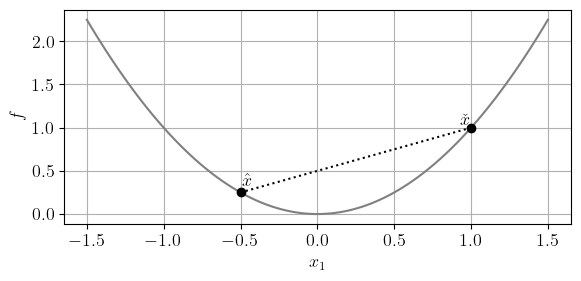

In [3]:
# Domain
x = torch.linspace(-1.5, 1.5, 100)

# Plot the function
fig = plt.figure(figsize=(6, 3))
plt.plot(x, x**2, "gray")

# Plot settings
plt.plot([-0.5, 1], [0.25, 1], ":k")
plt.annotate("$\hat{x}$", [-0.49, 0.33])
plt.plot([-0.5], [0.25], "ok")
plt.plot([1.0], [1.0], "ok")
plt.annotate("$\check{x}$", [0.93, 1.03])
plt.xlabel("$x_1$")
plt.ylabel("$f$")
plt.grid()
plt.tight_layout()
plt.savefig("../figures/convex_function_0.pdf", transparent=True)
plt.savefig("../figures/convex_function_0.svg", transparent=True)
plt.show()

## Example 10

The function $f_1(x, y)=x^4-x^2+y^2$ is not strictly convex, because its Hessian 
$$
    \nabla^2f_1(x,y) = 
    \begin{pmatrix}
    12x^2-2 & 0 \\ 
    0       & 2         
    \end{pmatrix}
$$
is not positive definite. Visually this means, we can find two points, for which drawing a line between them would cross the function. 

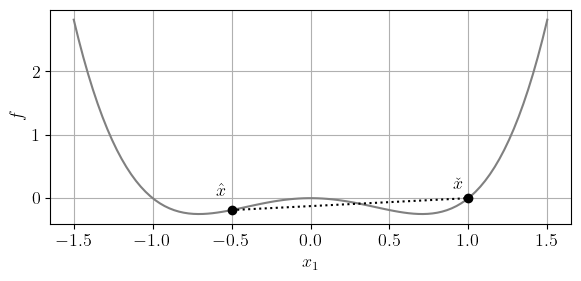

In [4]:
# Domain
x = torch.linspace(-1.5, 1.5, 100)

# Plot the functiom
fig = plt.figure(figsize=(6, 3))
plt.plot(x, x**4 - x**2, "gray")

# Plot settings
plt.plot([-0.5, 1], [-0.1875, 0], ":k")
plt.annotate("$\hat{x}$", [-0.6, 0.03])
plt.annotate("$\check{x}$", [0.9, 0.15])
plt.plot([-0.5], [-0.1875], "ok")
plt.plot([1.0], [0.0], "ok")
plt.xlabel("$x_1$")
plt.ylabel("$f$")
plt.grid()
plt.tight_layout()
plt.savefig("../figures/convex_function_1.pdf", transparent=True)
plt.savefig("../figures/convex_function_1.svg", transparent=True)
plt.show()

## Example 11: Simple steepest decent
We want to find the solution of the following quadratic unconstrained optimization problem
$$
            \min_{\mathbf{x}}  f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})
$$
with 
$$
        \mathbf{Q} = 
        \begin{pmatrix}
        2 & 1 \\
        1 & 1 
        \end{pmatrix}
        \quad \text{and} \quad
        \tilde{\mathbf{x}} = 
        \begin{pmatrix}
        -1\\
        1 
        \end{pmatrix}
        .
$$

The optimization path of a simple steepest decent method with a starting point $\mathbf{x}^0= (4, -1)^\top$ and $\eta=0.1$ is shown in the plot below with a blue line. However, the solution requires quite a lot of iterations.

    

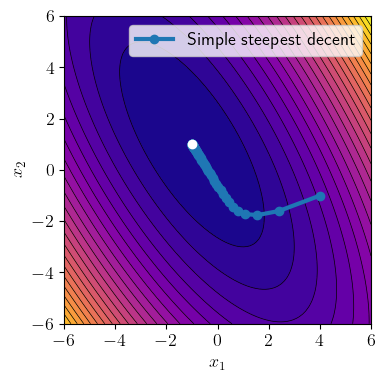

In [5]:
# Define domain
x0 = torch.linspace(-6, 6, steps=100)
x1 = torch.linspace(-6, 6, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing="xy"), dim=2)

# Define constants
xt = torch.tensor([-1.0, 1.0])
Q = torch.tensor([[2.0, 1.0], [1, 1.0]])


# Define function
def f(x):
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


def simple_decent(x_init, func, eta=0.1, max_iter=100):
    # Copy initial x to new differentiable tensor x
    x = x_init.clone().requires_grad_()

    points = [x]
    for _ in range(max_iter):
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Make a step
        x = x - eta * grad
        # Save intermediate results
        points.append(x)

    return points


x_init = torch.tensor([4.0, -1.0])
path = simple_decent(x_init, f)
plot_contours(
    x, f(x), opti=[-1, 1], paths={"Simple steepest decent": path}, figsize=(4, 4)
)
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.savefig("../figures/simple_decent.svg", transparent=True)

## Example 12: Armijo condition

Consider the function $f(x)$ displayed below. The Armijo condition is satisfied in all green ranges.  

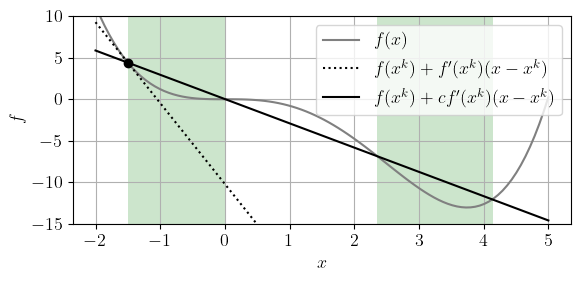

In [6]:
# Domain
x = torch.linspace(-2, 5, 100)

# Function
f = lambda x: (0.1 * x) ** 2 - x**3 + 0.2 * x**4
# Analytical derivative
f_d = lambda x: 0.2 * x - 3 * x**2 + 0.8 * x**3
# Linearization
g = lambda x, c: f(-1.5) + c * f_d(-1.5) * (x + 1.5)

# Plot lines
fig = plt.figure(figsize=(6, 3))
plt.plot(x, f(x), "gray", label="$f(x)$")
plt.plot(x, g(x, 1), ":k", label="$f(x^k) + f'(x^k) (x-x^k)$")
plt.plot(x, g(x, 0.3), "-k", label="$f(x^k) + c f'(x^k) (x-x^k)$")
plt.plot([-1.5], [f(-1.5)], "ok")

# Mark regions
rect = patches.Rectangle(
    (-1.5, -15), 1.5, 25, linewidth=1, facecolor="green", alpha=0.2
)
plt.gca().add_patch(rect)
rect = patches.Rectangle(
    (2.35, -15), 1.8, 25, linewidth=1, facecolor="green", alpha=0.2
)
plt.gca().add_patch(rect)

# Plot settings
plt.ylim([-15, 10])
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../figures/armijo_condition.pdf", transparent=True)
plt.savefig("../figures/armijo_condition.svg", transparent=True)
plt.show()

## Example 13: Steepest decent with incomplete line search

We consider the optimization problem stated in Example 11 using a steepest decent method with incomplete line search. The optimization path for a starting point $\mathbf{x}^0= (4, -1)^\top$, $\eta^0=5.0$, $c=0.5$, and $\rho=0.8$ is shown in the plot below with a blue line. The solution converges much faster than the simple steepest decent.
    

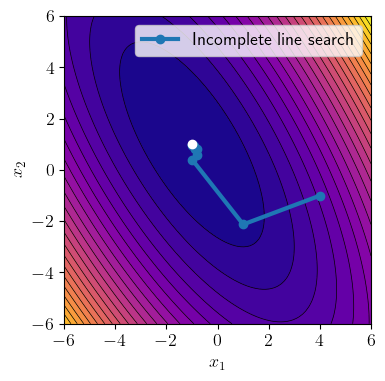

In [7]:
# Define domain
x0 = torch.linspace(-6, 6, steps=100)
x1 = torch.linspace(-6, 6, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing="xy"), dim=2)

# Define constants
xt = torch.tensor([-1.0, 1.0])
Q = torch.tensor([[2.0, 1.0], [1, 1.0]])


# Define function
def f(x):
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


def incomplete_line_search(x_init, func, eta_0=5.0, c=0.5, rho=0.8, max_iter=10):
    # Copy initial x to new differentiable tensor x
    x = x_init.clone().requires_grad_()

    points = [x]
    for _ in range(max_iter):
        # Compute direction
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        grad_norm = grad.norm()
        p = -grad / grad_norm
        # Backtracking algorithm for incomplete line search
        eta = eta_0
        while func(x + eta * p) > func(x) + c * eta * torch.dot(grad, p):
            eta *= rho
        # Make a step
        x = x + eta * p
        # Save intermediate results
        points.append(x)

    return points


x_init = torch.tensor([4.0, -1.0])
path = incomplete_line_search(x_init, f)
plot_contours(
    x, f(x), opti=[-1, 1], paths={"Incomplete line search": path}, figsize=(4, 4)
)
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.savefig("../figures/steepest_decent.svg", transparent=True)

## Example 14: Conjugated gradients 

We consider the optimization problem stated in Example 11 using the CG method with incomplete line search for the sub-problem. The optimization path for a starting point $\mathbf{x}^0= (4, -1)^\top$, $\eta^0=5.0$, $c=0.5$, and $\rho=0.8$ is shown in the plot below with a blue line. The solution converges in just two iterations for this 2D problem, as the problem is quadratic.
    

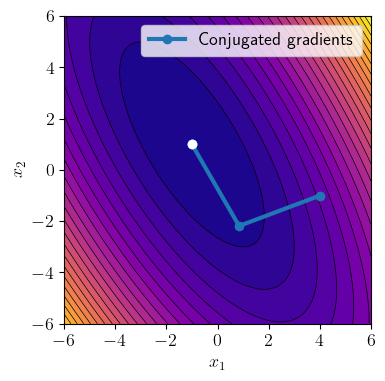

In [8]:
# Define domain
x0 = torch.linspace(-6, 6, steps=100)
x1 = torch.linspace(-6, 6, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing="xy"), dim=2)

# Define constants
xt = torch.tensor([-1.0, 1.0])
Q = torch.tensor([[2.0, 1.0], [1, 1.0]])


# Define function
def f(x):
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


def cg(x_init, func, max_iter=5):
    # Copy initial x to new differentiable tensor x
    x = x_init.clone().requires_grad_()

    points = [x]
    for i in range(max_iter):
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Compute conjugated direction
        if i > 0:
            beta = torch.dot(grad, grad) / torch.dot(grad_old, grad_old)
            p = -grad + beta * p_old
        else:
            p = -grad
        # Solve subproblem with incomplete line search
        eta_0 = torch.tensor([1.0])
        etas = incomplete_line_search(eta_0, lambda eta: func(x + eta * p))
        # Make a step
        x = x + etas[-1][0] * p
        # Store gradients
        grad_old = grad
        p_old = p
        # Save intermediate results
        points.append(x)

    return points


x_init = torch.tensor([4.0, -1.0])
path = cg(x_init, f)
plot_contours(
    x, f(x), opti=[-1, 1], paths={"Conjugated gradients": path}, figsize=(4, 4)
)
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.savefig("../figures/cg.svg", transparent=True)

## Example 15: Newton's method

Consider the nonlinear function $f(x) = x^2 - 3$ displayed below. To find a root, i.e. the values of $x$ where $f(x)=0$, we can employ Newtons method: 
1. Pick a starting point $x^0$.
2. Compute the derivative $f'(x)$.
3. Compute a new point $x^{k+1} = x^k - \frac{f(x^k)}{f'(x^k)}$.
4. Repeat the steps 2 and 3 until converged.

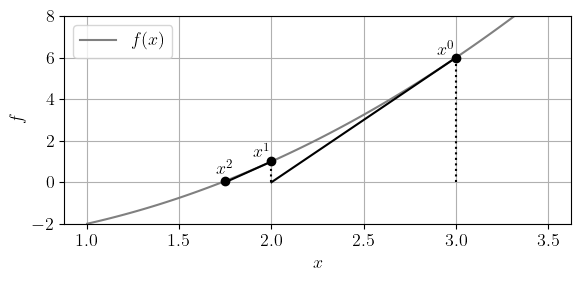

In [9]:
# Domain
x = torch.linspace(1, 3.5, 100)
# Domain for first linearization
xx = torch.linspace(2, 3, 100)
# Domain for second linearization
xxx = torch.linspace(1.75, 2, 100)

# Define the function
f = lambda x: x**2 - 3
# Analytical derivative of the function
f_d = lambda x: 2 * x
# First linearization
g = lambda x: f(3.0) + f_d(3) * (x - 3)
# Second linearization
h = lambda x: f(2.0) + f_d(2) * (x - 2)

# Plot lines and annotations
fig = plt.figure(figsize=(6, 3))
plt.plot(x, f(x), "gray", label="$f(x)$")
plt.plot([3, 3], [0, 6], ":k")
plt.plot([3], [f(3)], "ok")
plt.annotate("$x^0$", [2.9, 6.15])
plt.plot(xx, g(xx), "-k")
plt.plot([2], [f(2)], "ok")
plt.plot([2, 2], [0, 1], ":k")
plt.annotate("$x^1$", [1.9, 1.2])
plt.plot(xxx, h(xxx), "-k")
plt.plot([1.75], [f(1.75)], "ok")
plt.plot([1.75, 1.75], [0, 0.0625], ":k")
plt.annotate("$x^2$", [1.7, 0.4])

# Plot settings
plt.ylim([-2, 8])
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../figures/netwon_iteration.pdf", transparent=True)
plt.savefig("../figures/netwon_iteration.svg", transparent=True)
plt.show()

## Example 16: BFGS
We consider the optimization problem stated in Example 11 using the BFGS method with incomplete line search for the sub-problem. The optimization path for a starting point $\mathbf{x}^0= (4, -1)^\top$, $\eta^0=5.0$, $c=0.5$, and $\rho=0.8$ is shown in the plot below with a blue line. The solution converges in just two iterations for this 2D quadratic problem.
    

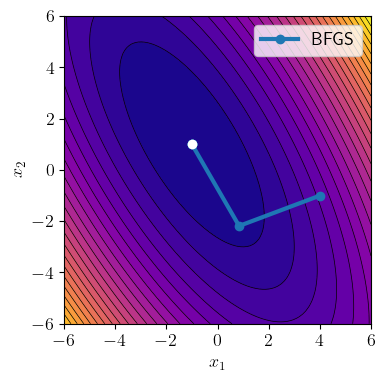

In [10]:
# Define domain
x0 = torch.linspace(-6, 6, steps=100)
x1 = torch.linspace(-6, 6, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing="xy"), dim=2)

# Define constants
xt = torch.tensor([-1.0, 1.0])
Q = torch.tensor([[2.0, 1.0], [1, 1.0]])


# Define function
def f(x):
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


def bfgs(x_init, func, max_iter=5):
    # Copy initial x to new differentiable tensor x
    x = x_init.clone().requires_grad_()

    points = [x]
    d = x.size(dim=0)
    I = torch.eye(d)
    H_i = I.clone()
    for _ in range(max_iter):
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Compute search direction
        p = -H_i @ grad
        # Solve subproblem with incomplete line search decent
        eta_0 = torch.tensor([1.0])
        etas = incomplete_line_search(eta_0, lambda eta: func(x + eta * p))
        # Make a step
        x = x + etas[-1][0] * p
        # Difference of gradients
        y = torch.autograd.grad(func(x).sum(), x)[0] - grad
        py = torch.inner(p, y)
        H_i = (I - torch.outer(p, y) / py) @ H_i @ (
            I - torch.outer(y, p) / py
        ) + torch.outer(p, p) / py
        # Save intermediate results
        points.append(x)

    return points


x_init = torch.tensor([4.0, -1.0])
path = bfgs(x_init, f)
plot_contours(x, f(x), opti=[-1, 1], paths={"BFGS": path}, figsize=(4, 4))
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.savefig("../figures/bfgs.svg", transparent=True)